# Lab session: model based optimization and experimental design

Autumn school, September 2019

Written by Javier Gonzalez

The goal of this lab session is to illustrate the concepts seen during the lecture "Model based optimization and experimental design". In the first part of the lab we will focus on two aspects of Bayesian Optimization (BO): (1) the choice of the model (2) the choice of the acquisition function. In the second part we will address a simplified version of the gene design case-study detailed in the lecture.

The technical material associated to the methods used in this lab can be found in the slides of the leture. 

## 1. Getting started

In this lab we will use Emukit (https://amzn.github.io/emukit/). Please be sure that it is correctly installed before starting. The easiest way is using pip. In Ubuntu machines you can do:

```
pip install emukit
```    

We will also use GPy (https://sheffieldml.github.io/GPy/). Please be sure that this are installed. With everything installed, you are ready to start. 

Now, just as in the previous lab, specify to include plots in the notebook and to import relevant libraries.

In [1]:
%pylab inline  
import GPy
import emukit
import numpy as np
from numpy.random import seed
seed(12345) # to make sure the lab is repoducible

### --- Figure config
LEGEND_SIZE = 15
FIGURE_SIZE = (8,6)

Populating the interactive namespace from numpy and matplotlib


## 2.  Remembering the basics

Before starting with the lab, remember that (BO) is an heuristic for global optimization of black-box functions. Let $f: {\mathcal X} \to R$ be a 'well behaved' continuous function defined on a compact subset ${\mathcal X} \subseteq R^d$. Our goal is to solve the global optimization problem of finding
$$ x_{M} = \arg \min_{x \in {\mathcal X}} f(x). $$

We assume that $f$ is a *black-box* from which only perturbed evaluations of the type $y_i = f(x_i) + \epsilon_i$, with $\epsilon_i \sim\mathcal{N}(0,\sigma^2)$, are  available. The goal is to find $x_M$ by minimizing the number of evaluations of $f$. To do this, we need to determine two crucial bits:

1. A **Gaussian process** that will capture the our beliefs on $f$. 

2. An **acquisition function** that based on the model will be useful to determine where to collect new evaluations of f. 

Remember that every time a new data point is collected the model is updated and the acquisition function optimized again. 

## 3. Running example step by step

We start with a one-dimensional example. Consider here the Forrester function 

$$f(x) =(6x-2)^2 \sin(12x-4),$$ defined on the interval $[0, 1]$. 

The minimum of this function is located at $x_{min}=0.78$. We assume that the evaluations of $f$ to are perturbed by zero-mean Gaussian noise with standard deviation 0.1. The Forrester function is part of the benchmark of functions of GPyOpt. To create the true function, the perturbed version and the boundaries of the problem you need to run the following cell. 

In [2]:
from emukit.test_functions import forrester_function
from emukit.core.loop.user_function import UserFunctionWrapper
from emukit.core import ContinuousParameter, ParameterSpace

target_function, space = forrester_function() 

The space object defines the input space X=[0,1], which in this case is purely continuous and only one dimensional. In a later section we will see how we can also apply Bayesian optimization in other domains that contain discrete or categorical parameters.

Of course in reality, evaluating f on a grid wouldn't be possible, but since the forrester function is a synthetic function we can evaluate it here for visualization purposes.

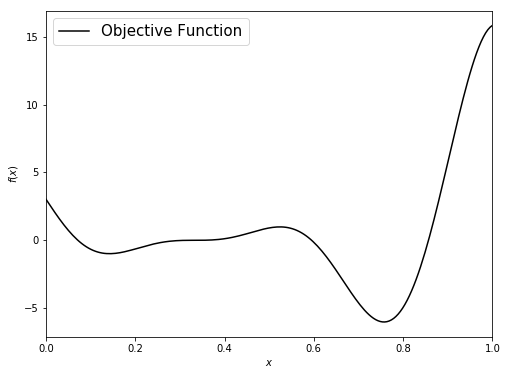

In [3]:
x_plot = np.linspace(space.parameters[0].min, space.parameters[0].max, 200)[:, None]
y_plot = target_function(x_plot)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xlim(0, 1)
plt.show()

**The Intial Design**: Usually, before we start the actual BO loop we need to gather a few observations such that we can fit the model. This is called the initial design and common strategies are either a predefined grid or sampling points uniformly at random.

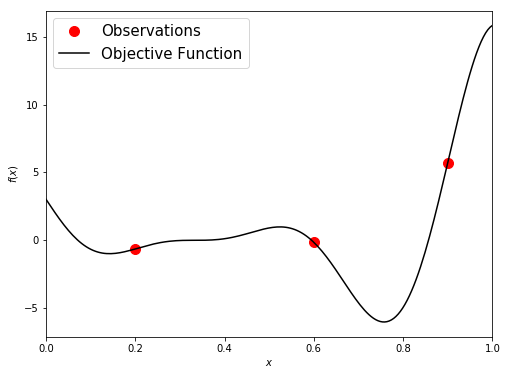

In [4]:
X_init = np.array([[0.2],[0.6], [0.9]])
Y_init = target_function(X_init)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(X_init, Y_init, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xlim(0, 1)
plt.show()

**The model**: Now we can start with the BO loop by first fitting a model on the collected data. The arguably most popular model for BO is a Gaussian process (GP) which defines a probability distribution across classes of functions, typically smooth, such that each linear finite-dimensional restriction is multivariate Gaussian (Rasmussen and Williams, 2006). In the next cell we create a model with GPy and we wrap it in Emukit

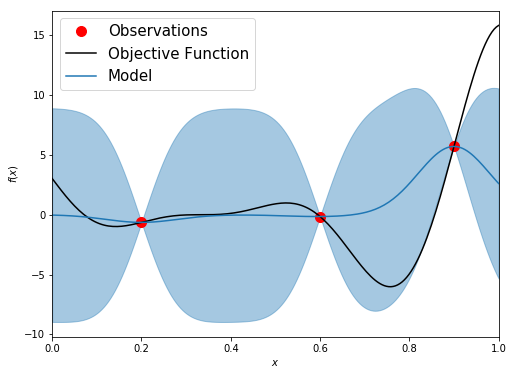

In [5]:
import GPy
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper

gpy_model = GPy.models.GPRegression(X_init, Y_init, GPy.kern.RBF(1, lengthscale=0.08, variance=20), noise_var=1e-10)
emukit_model = GPyModelWrapper(gpy_model)

mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(X_init, Y_init, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xlim(0, 1)
plt.show()

**The acquisition function**: The second thing we need is an acquisition fucntion, the object that we are going to use to design experiments that will get us closer the minimum of $f$. In this tutorial we will use the expected improvement.

In [6]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement

ei_acquisition = ExpectedImprovement(emukit_model)

For the current model we can visualize this acquisition.

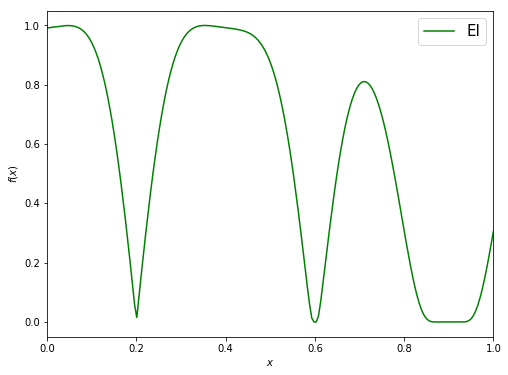

In [7]:
ei_plot = ei_acquisition.evaluate(x_plot)


plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot, (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)), "green", label="EI")

plt.legend(loc=1, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xlim(0, 1)
plt.show()

The location where this function reaches its maximum is the place where we need to run the next experiment. We can know which point is that by using a gradient based optimizer.

Location of next experiment: 0.35357576955963055


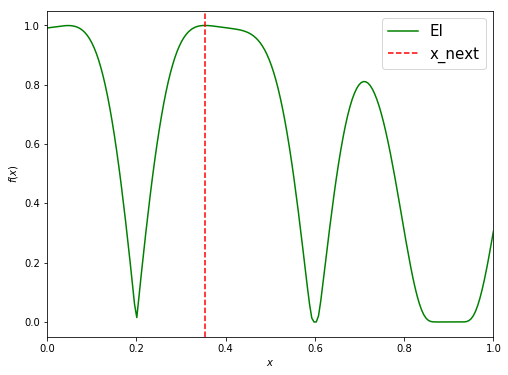

In [8]:
from emukit.core.optimization import GradientAcquisitionOptimizer

optimizer = GradientAcquisitionOptimizer(space)
x_new, _ = optimizer.optimize(ei_acquisition)
print('Location of next experiment: ' + str(x_new[0,0]))

plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot, (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)), "green", label="EI")
plt.axvline(x_new, color="red", label="x_next", linestyle="--")
plt.legend(loc=1, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xlim(0, 1)
plt.show()

Afterwards we evaluate the true objective function and append it to our initial observations.

In [9]:
y_new = target_function(x_new)  ### run experiment at this location

X = np.append(X_init, x_new, axis=0) ### append to the current data set
Y = np.append(Y_init, y_new, axis=0)

emukit_model.set_data(X, Y) ### update the model

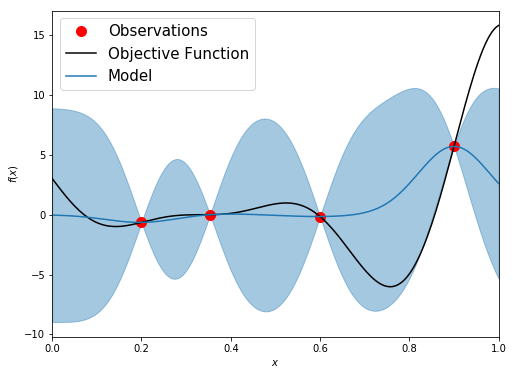

In [10]:
mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(emukit_model.X, emukit_model.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xlim(0, 1)
plt.show()

## 4. Running example - automatic loop 

Of course in practice we don't want to implement all of these steps our self. Emukit provides a convenient and flexible interface to apply Bayesian optimization. Below we can see how to run Bayesian optimization on the exact same function for 10 iterations.

First of all, we need to define the parameter space of the problem:

In [11]:
from emukit.core import ParameterSpace, ContinuousParameter
parameter_space = ParameterSpace([ContinuousParameter('x1', 0, 1)])

As we already have defined a model and an acquisition in the previous section, the only thing that we need to do now is to create a 'loop' so we can decide how many experiments we want to run. You can do this as follows:

In [12]:
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

bayesopt_loop = BayesianOptimizationLoop(model = emukit_model,
                                         space = parameter_space,
                                         acquisition = ei_acquisition)

And that's it, once the loop is created we run it for some iterations, 10 in our example.

In [13]:
max_iterations = 10
bayesopt_loop.run_loop(target_function, max_iterations)
results = bayesopt_loop.get_results()

Optimization restart 1/1, f = 9.66777505370643
Optimization restart 1/1, f = 12.407569132488604
Optimization restart 1/1, f = 13.801175515358985
Optimization restart 1/1, f = 15.11016835061318
Optimization restart 1/1, f = 18.83565621373558
Optimization restart 1/1, f = 20.896635740897693
Optimization restart 1/1, f = 19.103292479415934
Optimization restart 1/1, f = 13.616100943449684
Optimization restart 1/1, f = 5.664619184227783
Optimization restart 1/1, f = -2.4253804955045766
Optimization restart 1/1, f = -10.517173165876411


We can now check the final result and visualize the best found value after each iteration.

In [14]:
print('Optimal location: ' + str(results.minimum_location))
print('Value at optimimum :' + str(results.minimum_value))

Optimal location: [0.75726701]
Value at optimimum :-6.0207398779190315


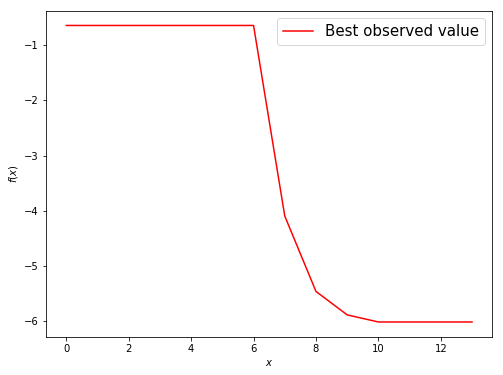

In [15]:
x_figure = np.array(list(range(len(results.best_found_value_per_iteration))))
plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_figure,results.best_found_value_per_iteration, "r-", markersize=10, label="Best observed value")
plt.legend(loc=1, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

And we can also visualize the final model

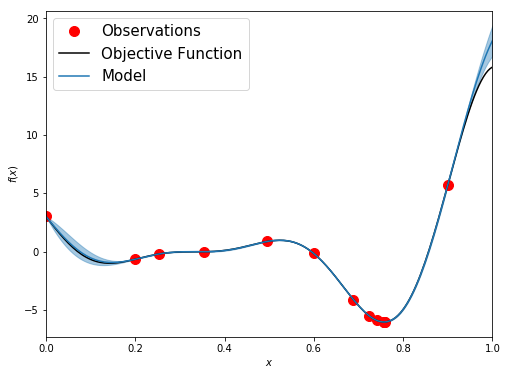

In [16]:
mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(emukit_model.X, emukit_model.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xlim(0, 1)
plt.show()

## Exercise: optimize your own gene

Imagine that you work in a lab and you know that the amount of protein produced by a synthetic gene depends on four features that can be extracted from the gene sequence:
   - AT ratio (between 0 and 1).
   - ATT codon ratio (between 0 and .1).
   - CGA codon ratio (between 0 and 0.2).
   - Free folding energy (between 0 and 3).

Your design space is therefore defined by:

In [17]:
from emukit.core import ParameterSpace, ContinuousParameter
import numpy as np

gene_design_space = ParameterSpace([ContinuousParameter('AT_ratio', 0, 1),
                               ContinuousParameter('ATT_ratio', 0, .50),
                               ContinuousParameter('CGA_ratio', 0, .50),
                               ContinuousParameter('free_energy', 0, 1)]
                             )

For each combination of these features you can run a lab experiment that returns the minus amount of protein produced by the gene. Virtually you can run those labs by importing the function test gene from the file weblab as follows:

In [18]:
from wetlab import test_gene

For instance, for a gene with AT_ratio = 0.5, ATT_ratio = 0.03, CGA_ratio = 0.05 and free_energy= 2.3 you can extract the minus amount of protein produced by running:

In [19]:
new_gene = np.array([[0.5,0.03,0.05,2.3]])
test_gene(new_gene)

array([[-3.99538983]])

Each experiment costs 1K£ and you have a you have a budget of 60K£. Can you answer the following question 

**Which is the best possible combination of features in terms of the amount of protein produced by the gene?**

In [20]:
# Solution


## initial design
from emukit.experimental_design.model_free.random_design import RandomDesign
design = RandomDesign(gene_design_space) # Collect random points
num_data_points = 10
X = design.get_samples(num_data_points)
Y = test_gene(X)

## model
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
model_protein_production = GPRegression(X,Y) # Train and wrap the model in Emukit
model_emukit_protein_production = GPyModelWrapper(model_protein_production)

## acquisition
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
expected_improvement = ExpectedImprovement(model = model_emukit_protein_production)

## loop
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
bayesopt_loop = BayesianOptimizationLoop(model = model_emukit_protein_production,
                                         space = gene_design_space,
                                         acquisition = expected_improvement,
                                         batch_size = 1)
## experiments
max_iterations = 50
bayesopt_loop.run_loop(test_gene, max_iterations)



Optimization restart 1/1, f = 7.475035188774705
Optimization restart 1/1, f = 8.750217374907816
Optimization restart 1/1, f = 8.711147362877991
Optimization restart 1/1, f = 15.489336893922754
Optimization restart 1/1, f = 16.13776446836596
Optimization restart 1/1, f = 16.393926449501286
Optimization restart 1/1, f = 17.04488972554711
Optimization restart 1/1, f = 17.13728065108036
Optimization restart 1/1, f = 17.219297590992184
Optimization restart 1/1, f = 16.322607943038633
Optimization restart 1/1, f = 15.166541423885384
Optimization restart 1/1, f = 17.26529413691752
Optimization restart 1/1, f = 18.319920606996366
Optimization restart 1/1, f = 18.708313779859125
Optimization restart 1/1, f = 19.9868231425661
Optimization restart 1/1, f = 16.929913070037227
Optimization restart 1/1, f = 18.56882319426967
Optimization restart 1/1, f = 19.79604049530919
Optimization restart 1/1, f = 15.880519440541665
Optimization restart 1/1, f = 15.738798466588445
Optimization restart 1/1, f = 1

Optimal AT ratio: 0.0
Optimal ATT ration: 0.3530548185857528
Optimal CGA ration: 0.0
Optimal free energy: 0.2828729803752647
Amount of protein produced :5.999992056843602


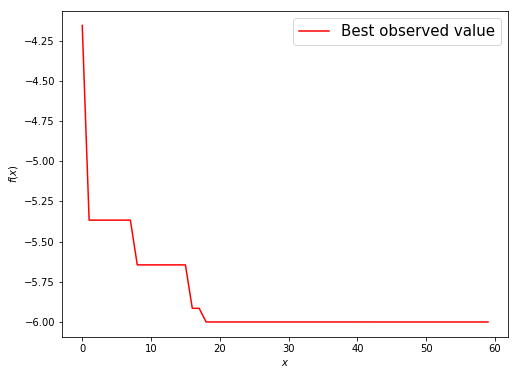

In [21]:
## results
results = bayesopt_loop.get_results()
print('Optimal AT ratio: ' + str(results.minimum_location[0]))
print('Optimal ATT ration: ' + str(results.minimum_location[1]))
print('Optimal CGA ration: ' + str(results.minimum_location[2]))
print('Optimal free energy: ' + str(results.minimum_location[3]))
print('Amount of protein produced :' + str(-results.minimum_value))

x_figure = np.array(list(range(len(results.best_found_value_per_iteration))))
plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_figure,results.best_found_value_per_iteration, "r-", markersize=10, label="Best observed value")
plt.legend(loc=1, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()
